In [3]:
from skimage.data import camera
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift # i prefix = inverse.
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
font = {'size': 18}

In [7]:
im = camera()
im_fft = fftshift(fftn(im))
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Image', fontdict=font)
ax[1].imshow(np.log(np.abs(im_fft)))
ax[1].set_title('FFT Magnitude (log)', fontdict=font)

Text(0.5, 1.0, 'FFT Magnitude (log)')

In [14]:
from skimage.draw import circle
cutoff = 30
center = np.array(im.shape) / 2 - 0.5
print(f'Shape = {im.shape}\tCenter = {center}')
# Low pass filter.
lpf = np.zeros_like(im)
lpf[circle(*center, cutoff)] = 1
# High pass filter.
hpf = np.ones_like(im)
hpf[circle(*center, cutoff)] = 0
# Band pass filter.
bpf = lpf.copy()
bpf[circle(*center, cutoff / 2)] = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 10), sharey=True)
ax[0].set_title('Low-pass filter', fontdict=font)
ax[0].imshow(lpf)
ax[1].set_title('High-pass filter', fontdict=font)
ax[1].imshow(hpf)
ax[2].set_title('Band-pass filter', fontdict=font)
ax[2].imshow(bpf)

Shape = (512, 512)	Center = [255.5 255.5]


In [22]:
lp_fft = im_fft * lpf
lp_im = ifftn(ifftshift(lp_fft))
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(np.log1p(np.abs(lp_fft)))
ax[1].imshow(lp_im.real, cmap='gray')

In [62]:
from skimage.filters import gaussian
from skimage import img_as_float  # Convert image frmo 8-bit to 0-1 float.
imf = img_as_float(im)
gf_im = list()
gf_im += [gaussian(imf, 4)]  # sigma of 4 pixels.
gf_im += [gaussian(imf, 12)]
g_hpf_im = imf - gf_im[0]
g_bpf_im = gf_im[0] - gf_im[1]
g_lpf_fft = fftshift(fftn(gf_im[0]))
g_hpf_fft = fftshift(fftn(g_hpf_im))
g_bpf_fft = fftshift(fftn(g_bpf_im))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=True)
for k, im in enumerate([g_lpf_fft, g_hpf_fft, g_bpf_fft, gf_im[0], g_hpf_im, g_bpf_im]):
    print(f'k = {k}, i = {k // 3}, j = {k % 3}')
    ax[i, j].imshow(im)

ValueError: Can not convert from complex128 to float64.

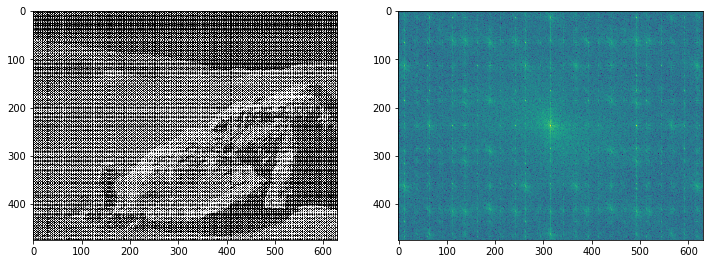

In [36]:
from skimage import io
image = io.imread('../data/moonlanding.png')
im_fft = fftshift(fftn(image))
im_fft_mag = np.abs(im_fft)
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(np.log(im_fft_mag))

In [39]:
# Simple solution is using a low pass filter.
im_lpf = gaussian(image, 4)  # Pre-baked the cake, so we know 4 will work.
im_fft_lpf = fftshift(fftn(im_lpf))
im_fft_lpf_mag = np.abs(im_fft_lpf)
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(im_lpf, cmap='gray')
ax[1].imshow(np.log(im_fft_lpf_mag))

In [45]:
# Elegant SciPy way, but using better variable names.
mask = im_fft_mag.copy()
M, N = mask.shape
K = 40  # cutoff
# Take a square around the center point.
# Note that scikit-image has a function to draw squares
# which would make this easier.
mask[M // 2 - K:M // 2 + K,
     N // 2 - K:N // 2 + K] = 0
mask = mask < np.percentile(mask, 98)
plt.imshow(mask, cmap='gray')

In [55]:
im_fft_nopeaks = im_fft * mask
plt.imshow(np.log1p(np.abs(im_fft_nopeaks)))

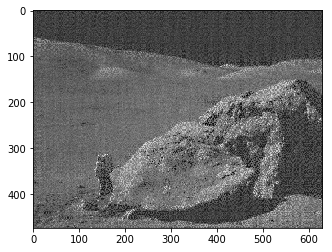

In [60]:
im_flt = np.abs(ifftn(im_fft_nopeaks))
plt.imshow(im_flt, cmap='gray')

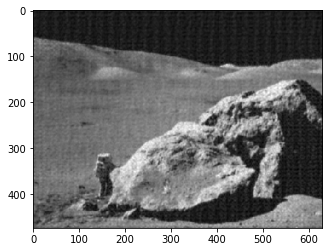

In [61]:
# Clean up high frequency noise using a modest gaussian filter.
im_smooth = gaussian(im_flt, 1.5)
plt.imshow(im_smooth, cmap='gray')

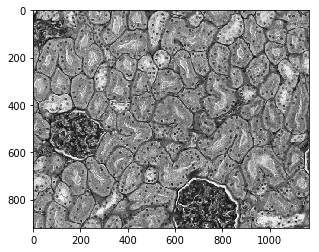

In [73]:
# Aligning images with similar frequencies using phase difference.
from skimage.color import rgb2gray
image = io.imread('../data/bear_kidney.png')
image = rgb2gray(image)
# Pick values to shift one image w.r.t the other.
row_shift = 82
col_shift = 137
image1 = image[row_shift:, col_shift:]
image2 = image[:-row_shift, :-col_shift]
plt.imshow(image, cmap='gray')

In [77]:
# Underneath the covers,
# correcting for the shift uses the complex conjugate.
num = 5 + 6j
print(f'{num}\t{num.conjugate()}\t{num * num.conjugate()}')

(5+6j)	(5-6j)	(61+0j)


In [81]:
fft1 = fftshift(fftn(image1))
fft2 = fftshift(fftn(image2))
fft2_cc = np.conjugate(fft2)
numerator = fft1 * fft2_cc
denominator = np.abs(numerator)
cross_power_spectrum = numerator / denominator

/home/omsai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


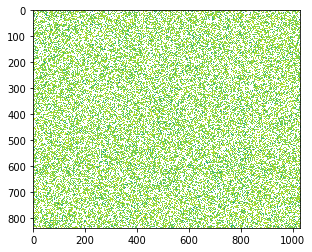

In [87]:
phase_correlation = ifftn(cross_power_spectrum).real
plt.imshow(np.log(phase_correlation))
# Hard to see what's going on in the image.

In [98]:
where = np.where(phase_correlation == phase_correlation.max())
where

(array([756]), array([891]))

In [99]:
where = np.concatenate(where)
where

array([756, 891])

In [100]:
np.array(image1.shape) - where

array([ 82, 139])

In [101]:
np.array([row_shift, col_shift])

array([ 82, 137])

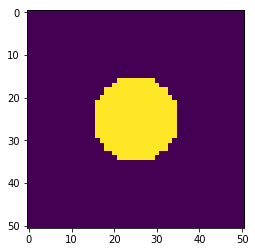

In [102]:
from scipy.ndimage import convolve
input_image = np.zeros((51, 51))
circle_coords = circle(25, 25, 10)
input_image[circle_coords] = 1
plt.imshow(input_image)

In [103]:
# Edge detecting kernel.
kernel = [[-1, 0, 1],
          [-1, 0, 1],
          [-1, 0, 1]]
np.array(kernel)

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

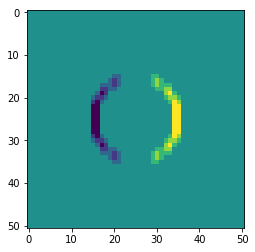

In [104]:
# Convolve with our circle.
output_image = convolve(input_image, kernel)
plt.imshow(output_image)

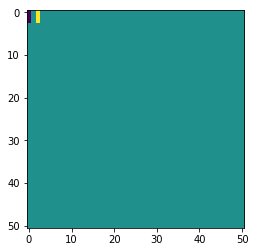

In [109]:
# How does the convolution relate to the FFT?
# Convolution is a spatial domain operation.
# Convolution in spational domain = multiplication in frequency domain.
# Let's see how that's true.
# First we need to make the kernel the same size as the image using zero padding.
kernel_pad = np.pad(kernel, ((0, 48), (0, 48)), 'constant')
plt.imshow(kernel_pad)

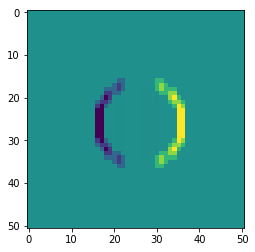

In [111]:
f_input = fftn(input_image)
f_kernel = fftn(kernel_pad)
f_output = f_input * f_kernel
output_image = ifftn(f_output)
plt.imshow(output_image.real)

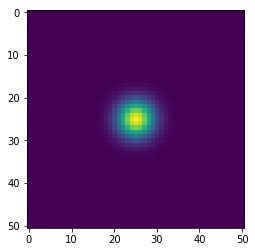

In [135]:
# Question about gaussian.
im = np.zeros((51, 51))
im[25, 25] = 1
im = gaussian(im, 3)
plt.imshow(im)

In [136]:
plt.imshow(fftshift(fftn(im)).real)

# Challenges

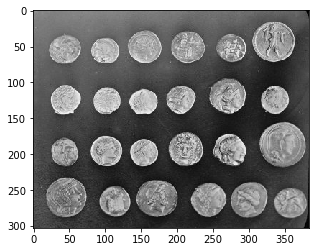

In [137]:
from skimage.data import coins
image = coins()
plt.imshow(image, cmap='gray')
# Largest coin has a diameter of about 50 pixels.

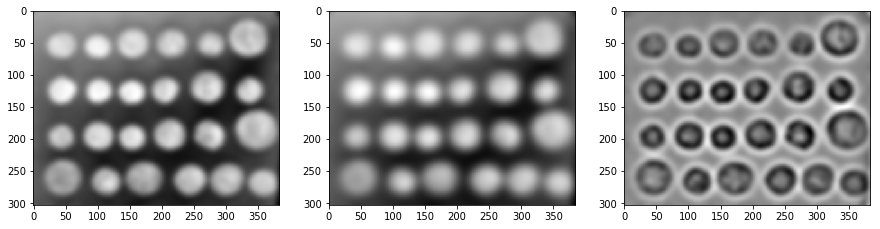

In [167]:
# Difference of gaussians.
sigma = 5
sigmas = [sigma, sigma * 1.6]
im_blurs = np.array([gaussian(image, sigma) for sigma in sigmas])
im_blur_diff = np.diff(im_blurs, axis=0)
im_blur_all = np.concatenate((im_blurs, im_blur_diff))
n = im_blur_all.shape[0]
fig, ax = plt.subplots(ncols=n, figsize=(15, 10))
for i in range(n):
    ax[i].imshow(im_blur_all[i, :, :], cmap='gray')

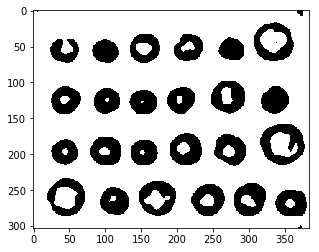

In [174]:
im_diff = np.squeeze(im_blur_diff)
plt.imshow(im_diff > np.percentile(im_diff, 25), cmap='gray')
# Proper way to do this is with skimage.feature.blob_detector
# Reading the documentation should make more sense now that you
# know what's going on.